In [1]:
from datetime import datetime, timedelta
from enum import Enum
import sys
import time
import threading
import numpy as np
import uhd
from uhd import libpyuhd as lib
import matplotlib.pyplot as plt

INIT_DELAY = 0.1
CHIRP_LEN = 80000
CHIRP_BANDWIDTH = 0.5e6


class States(Enum):
    """Enumerations to represent different states."""
    TUNE_CENTER_FREQ = 1
    RX_AND_SAVE_DATA = 2
    DONE = 3

class StateManager:
    """Class to manage state transitions."""
    def __init__(self):
        self.state = States.TUNE_CENTER_FREQ

    def set_state(self, state):
        self.state = state

    def get_state(self):
        return self.state

state_manager = StateManager()     
        
def tune_center_freq(usrp, current_freq, channel_list, tx_gain, tx_gain2, rx_gaina, rx_gainb):
    print('tuning freq')
    """Tune the center frequency and set the appropriate gain."""
    # Tune the center frequencies
    usrp.set_rx_freq(lib.types.tune_request(current_freq), 0)
    usrp.set_rx_freq(lib.types.tune_request(current_freq), 1)
    usrp.set_tx_freq(lib.types.tune_request(current_freq), 0)
    usrp.set_tx_freq(lib.types.tune_request(current_freq), 1)
    
    usrp.set_tx_gain(tx_gain, channel_list[0])
    usrp.set_rx_gain(rx_gaina, channel_list[0])
    usrp.set_rx_gain(rx_gainb, channel_list[1])

    # Wait for the local oscillators to lock
    while not(
        usrp.get_rx_sensor("lo_locked", 0).to_bool()
        and usrp.get_tx_sensor("lo_locked", 0).to_bool()
        ):
        pass
    state_manager.set_state(States.RX_AND_SAVE_DATA)
    return

def rx_worker(usrp, current_freq, rx_streamer, num_samps, rx_buffer_list, rx_buffer_list_ch2, wait_time):

    num_iter=0
    num_rx_samps =0
    received_samples = []
    received_samples_ch2 = []
    
    # Make a receive buffer
    num_channels = rx_streamer.get_num_channels()
    print("num channels: ", num_channels)
    max_samps_per_packet = rx_streamer.get_max_num_samps()
    print(max_samps_per_packet)
    recv_buffer = np.empty((num_channels, max_samps_per_packet), dtype=np.complex64)
    metadata = uhd.types.RXMetadata()

    # Craft and send the Stream Command
    stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.start_cont)
    stream_cmd.stream_now = False
    stream_cmd.time_spec = uhd.types.TimeSpec(wait_time)
    rx_streamer.issue_stream_cmd(stream_cmd)
    
    # Receive until we get the signal to stop
    while num_rx_samps < num_samps:
        stream_cmd.num_samps = max_samps_per_packet
        rx_streamer.issue_stream_cmd(stream_cmd)
        num_rx_samps += rx_streamer.recv(recv_buffer, metadata)

        if (num_rx_samps >= 10):
            received_samples.extend(recv_buffer[0].tolist())
            received_samples_ch2.extend(recv_buffer[1].tolist())
            num_iter+=1
            
    print(num_iter)
    print(len(received_samples))

    # plt.plot(received_samples)
    # plt.show()

    paired_samples = [(sample, current_freq) for sample in received_samples]
    paired_samples_ch2 = [(sample, current_freq) for sample in received_samples_ch2]
    
    rx_buffer_list.extend(paired_samples)
    rx_buffer_list_ch2.extend(paired_samples_ch2)
 
    print("Finished RX")
    rx_streamer.issue_stream_cmd(uhd.types.StreamCMD(uhd.types.StreamMode.stop_cont))

    state_manager.set_state(States.TUNE_CENTER_FREQ)

def tx_worker(usrp, tx_streamer, num_samps, tx_data, wait_time):
    
    num_channels = tx_streamer.get_num_channels()
    max_samps_per_packet = tx_streamer.get_max_num_samps()
    tx_md = uhd.types.TXMetadata()
    tx_md.start_of_burst = True
    tx_md.end_of_burst = False
    tx_md.has_time_spec = True
    tx_md.time_spec = uhd.types.TimeSpec(wait_time)

    tx_streamer.send(tx_data, tx_md)
    
    # Send a mini EOB packet
    tx_md.end_of_burst = True
    tx_streamer.send(np.zeros((num_channels, 0), dtype=np.complex64), tx_md)


def generate_tx_data(samp_rate):
    channel_list = (0,1)
    #generate chirps
    fs = samp_rate
    N2 = CHIRP_LEN
    bw = CHIRP_BANDWIDTH
    n= np.arange(0, N2-1)
    t = n/fs 

    send_chirp = np.array(np.exp(1j*np.pi*.5*(bw/t[-1])*(t**2)), dtype = np.complex64)
    N = 4096 #PADDING number
    send_chirp = np.pad(send_chirp, (N), 'constant', constant_values=(0))
    wave_ampl = 0.8

    #tile the data because two channels
    tx_data = np.tile(send_chirp, (1,1)) #tiles to send one period
    tx_data = np.tile(tx_data[0], (len(channel_list),1)) 

    #create metadata for tx
    tx_md = lib.types.tx_metadata()
    tx_md.start_of_burst = True
    tx_md.end_of_burst = False
    tx_md.has_time_spec = True

    chirp_len = send_chirp.size
    chirp_duration = chirp_len / samp_rate

    return tx_data, send_chirp, chirp_len, chirp_duration
 

In [2]:
current_freq = 310e6
end_freq = 320e6
samp_rate = 2e6
current_channels = [0,1]
step_freq = 2e6

usrp = uhd.usrp.MultiUSRP("num_recv_frames=800, num_send_frames=500")
usrp.set_clock_source("internal")

usrp.set_tx_rate(samp_rate)
usrp.set_rx_rate(samp_rate)

st_args = uhd.usrp.StreamArgs("fc32", "sc16")
st_args.channels = [0,1]

rx_streamer = usrp.get_rx_stream(st_args)
tx_streamer = usrp.get_tx_stream(st_args)

rx_buffer_list = []
rx_buffer_list_ch2 = []

tx_data, tx_md, send_chirp, chirp_len, chirp_duration = generate_tx_data(samp_rate)
usrp.set_time_now(lib.types.time_spec(0,0))

num_samps = chirp_len
print(num_samps)

count = 0

while True:
    if (state_manager.get_state() == States.TUNE_CENTER_FREQ):

        tune_center_freq(usrp, current_freq, current_channels, 50,50,50,50)
        current_freq += step_freq
            
    elif (state_manager.get_state() == States.RX_AND_SAVE_DATA):

        time.sleep(0.1)

        usrp.clear_command_time()

        wait_time = usrp.get_time_now().get_real_secs() + INIT_DELAY
        
        #create the workers
        rx_thread = threading.Thread(target=rx_worker, args=(usrp, current_freq, rx_streamer, num_samps, rx_buffer_list, rx_buffer_list_ch2, wait_time))
        tx_thread = threading.Thread(target=tx_worker, args=(usrp, tx_streamer, num_samps, tx_data, wait_time))
  
        rx_thread.start()
        tx_thread.start()
        
        rx_thread.join()
        tx_thread.join()

        print("Finished cycle")

        usrp.clear_command_time()

        count += 1

        if (count >= 2):
            state_manager.set_state(States.DONE)

        
    elif(state_manager.get_state() == States.DONE):
        print("done")
        break

np.save("rx_buffer.npy", rx_buffer_list)
np.save("rx_buffer2.npy", rx_buffer_list_ch2)


[INFO] [UHD] linux; GNU C++ version 12.3.0; Boost_108200; UHD_4.6.0.HEAD-release
[INFO] [B200] Detected Device: B210
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 32.000000 MHz... 
[INFO] [B200] Actually got clock rate 32.000000 MHz.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.


88191
tuning freq
num channels:  2
2040


UU

44
89760
Finished RX
Finished cycle
tuning freq
num channels:  2
2040
44
89760
Finished RX
Finished cycle
done


UU

Saved


/home/mhetu/miniconda3/envs/uhd_env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mhetu/miniconda3/envs/uhd_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


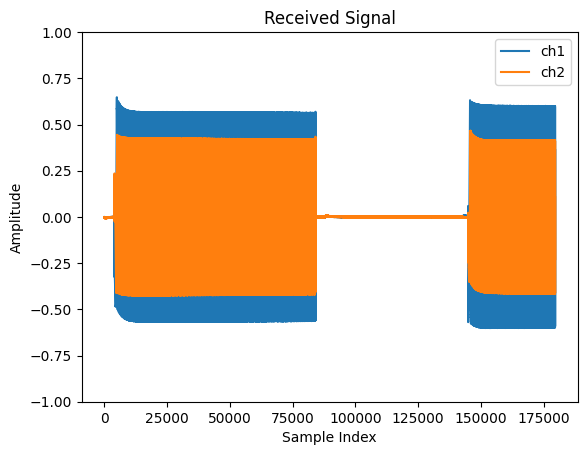

In [3]:
plt.figure()
print("Saved")
plt.plot(list(datum[0] for datum in rx_buffer_list), label="ch1")
plt.plot(list(datum[0] for datum in rx_buffer_list_ch2), label="ch2") 
plt.title('Received Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.ylim([-1, 1])
plt.legend()
plt.show()